# Setup

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import shutil

In [2]:
seed = 142

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data preparation

In [3]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        monet_dir = os.path.join(data_dir, 'monet_jpg')
        photo_dir = os.path.join(data_dir, 'photo_jpg')
        
        self.files_monet = [os.path.join(monet_dir, name) for name in sorted(os.listdir(monet_dir))]
        self.files_photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_monet)
    
    def __getitem__(self, index):
        random_index = np.random.randint(0, len(self.files_monet))
        file_monet = self.files_monet[index]
        file_photo = self.files_photo[random_index]
        
        image_monet = Image.open(file_monet)
        image_photo = Image.open(file_photo)
        
        if self.transforms is not None:
            image_monet = self.transforms(image_monet)
            image_photo = self.transforms(image_photo)
        
        return image_monet, image_photo

In [4]:
data_dir = '/kaggle/input/gan-getting-started'
batch_size = 5

In [5]:
transforms_ = transforms.Compose([
    # transforms.Resize(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

dataloader = DataLoader(
    ImageDataset(data_dir, transforms=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# Build CycleGAN

## Auxiliary blocks

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=0, use_leaky=True, transpose=False, normalize=True):
        
        super(ConvBlock, self).__init__()
        self.block = []
        
        if transpose:
            self.block += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                              stride, padding, output_padding=1)]
        else:
            self.block += [nn.Conv2d(in_channels, out_channels, kernel_size,
                                     stride, padding, bias=True)]
            
        if normalize:
            self.block += [nn.InstanceNorm2d(out_channels)]
            
        if use_leaky:
            self.block += [nn.LeakyReLU(negative_slope=0.2, inplace=True)]
        else:
            self.block += [nn.GELU()]
            
        self.block = nn.Sequential(*self.block)
    
    
    def forward(self, x):
        return self.block(x)
    

    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            ConvBlock(in_channels=in_channels, out_channels=in_channels, kernel_size=3, use_leaky=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels)
        )
    
    
    def forward(self, x):
        return x + self.block(x)

## Define Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        # Inital Convolution  3*256*256 -> 64*256*256
        self.initial = [
            nn.ReflectionPad2d(in_channels),
            ConvBlock(in_channels=in_channels, out_channels=64,
                      kernel_size=2*in_channels+1, use_leaky=False),
        ]
        self.initial = nn.Sequential(*self.initial)
        
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = [
            ConvBlock(in_channels=64, out_channels=128, kernel_size=3,
                      stride=2, padding=1, use_leaky=False),
            ConvBlock(in_channels=128, out_channels=256, kernel_size=3,
                      stride=2, padding=1, use_leaky=False),
        ]
        self.down = nn.Sequential(*self.down)
        
        
        # Transformation (ResNet)  256*64*64
        self.transform = [ResidualBlock(256) for _ in range(num_residual_blocks)]
        self.transform = nn.Sequential(*self.transform)
        
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = [
            ConvBlock(in_channels=256, out_channels=128, kernel_size=3,
                      stride=2, padding=1, transpose=True, use_leaky=False),
            ConvBlock(in_channels=128, out_channels=64, kernel_size=3,
                      stride=2, padding=1, transpose=True, use_leaky=False),
        ]
        self.up = nn.Sequential(*self.up)
        
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(out_channels),
            nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=2*out_channels+1),
            nn.Tanh()
        )
    
    
    def forward(self, x):
        x = self.initial(x)
        x = self.down(x)
        x = self.transform(x)
        x = self.up(x)
        x = self.out(x)
        
        return x

## Define Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # 3*256*256 -> 64*128*128 
            ConvBlock(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, normalize=False),
            
            # 64*128*128 -> 128*64*64
            ConvBlock(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            
            # 128*64*64 -> 256*32*32
            ConvBlock(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            
            # 256*32*32 -> 512*31*31
            ConvBlock(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),
            
            # 512*31*31 -> 1*30*30
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1),
        )
        
        
    def forward(self, x):
        return self.model(x)

# Training tools

## Model initialization

In [9]:
generator_monet2photo = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)
generator_photo2monet = Generator(in_channels=3, out_channels=3, num_residual_blocks=9).to(device)

discriminator_monet = Discriminator(in_channels=3).to(device)
discriminator_photo = Discriminator(in_channels=3).to(device)

## Define Losses

In [10]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## Define Optimizers

In [11]:
lr = 5e-4
b1 = 0.5
b2 = 0.998

optim_generators = torch.optim.Adam(
    list(generator_monet2photo.parameters()) + list(generator_photo2monet.parameters()),
    lr=lr, betas=(b1, b2)
)

optim_discriminators = torch.optim.Adam(
    list(discriminator_monet.parameters()) + list(discriminator_photo.parameters()),
    lr=lr, betas=(b1, b2)
)

## Define Learning rate schedulers

In [12]:
num_epochs = 50
decay_epoch = 10

lr_sched_step = lambda epoch: 1 - max(0, epoch - decay_epoch) / (num_epochs - decay_epoch)

lr_sched_generators = torch.optim.lr_scheduler.LambdaLR(optim_generators, lr_lambda=lr_sched_step)
lr_sched_discriminators = torch.optim.lr_scheduler.LambdaLR(optim_discriminators, lr_lambda=lr_sched_step)

# Training CycleGAN

In [13]:
class History():
    def __init__(self):
        self.generators_loss = []
        self.discriminators_loss = []
    
    def update(self, gen_loss, discr_loss):
        self.generators_loss.append(gen_loss)
        self.discriminators_loss.append(discr_loss)
        
    def show(self, title='Losses'):
        fig = plt.figure(figsize=(20, 8))
        plt.title(title)
        plt.plot(self.generators_loss, 'o-', color='r',
                 linewidth=2, markersize=3, label='Generators Loss')
        plt.plot(self.discriminators_loss, 'o-', color='b',
                 linewidth=2, markersize=3, label='Discriminators Loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
        
history = History()

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1/50 | Generators Loss: 5.8649 | Discriminators Loss: 1.3241


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 2/50 | Generators Loss: 4.6446 | Discriminators Loss: 0.5364


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 3/50 | Generators Loss: 4.6166 | Discriminators Loss: 0.5572


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 4/50 | Generators Loss: 4.2964 | Discriminators Loss: 0.6715


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 5/50 | Generators Loss: 4.1880 | Discriminators Loss: 0.4851


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 6/50 | Generators Loss: 4.1393 | Discriminators Loss: 0.4716


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 7/50 | Generators Loss: 4.3572 | Discriminators Loss: 1.4121


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 8/50 | Generators Loss: 3.7266 | Discriminators Loss: 0.4801


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 9/50 | Generators Loss: 3.6611 | Discriminators Loss: 0.4872


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 10/50 | Generators Loss: 3.6727 | Discriminators Loss: 0.4493


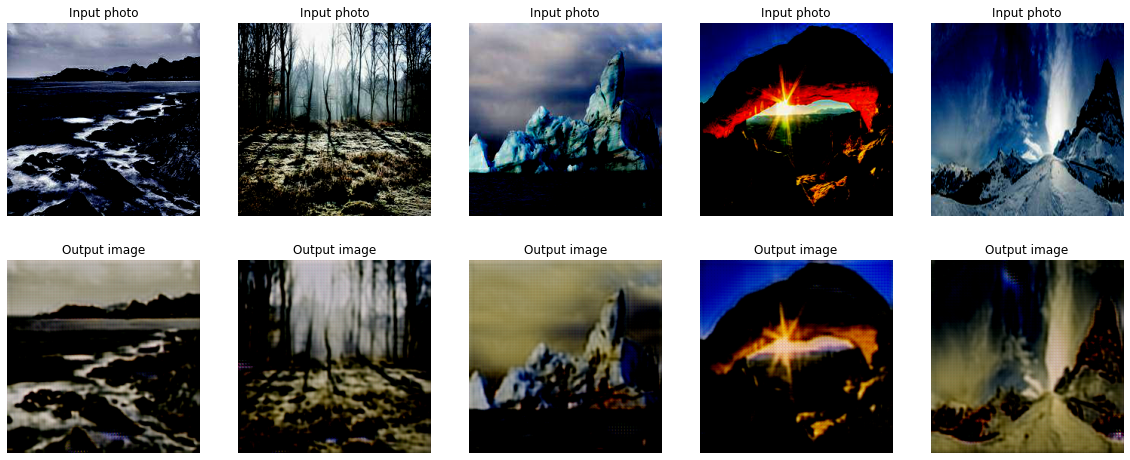

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 11/50 | Generators Loss: 3.8388 | Discriminators Loss: 0.4617


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 12/50 | Generators Loss: 3.7325 | Discriminators Loss: 0.4253


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 13/50 | Generators Loss: 3.6753 | Discriminators Loss: 0.4247


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 14/50 | Generators Loss: 3.7930 | Discriminators Loss: 0.4152


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 15/50 | Generators Loss: 3.7291 | Discriminators Loss: 0.3524


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 16/50 | Generators Loss: 3.6319 | Discriminators Loss: 0.4402


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 17/50 | Generators Loss: 3.6976 | Discriminators Loss: 0.3577


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 18/50 | Generators Loss: 3.5564 | Discriminators Loss: 0.3636


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 19/50 | Generators Loss: 3.6020 | Discriminators Loss: 0.3696


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 20/50 | Generators Loss: 3.5598 | Discriminators Loss: 0.3641


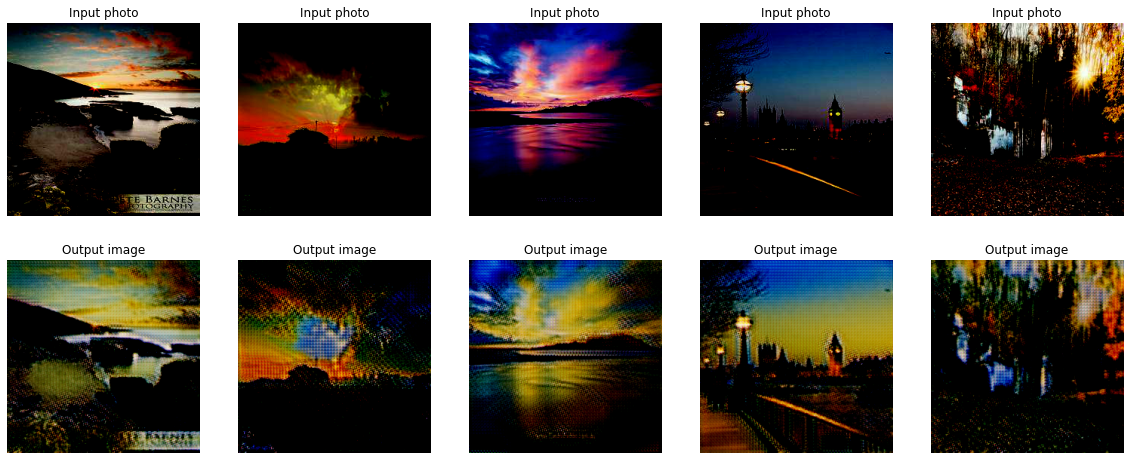

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 21/50 | Generators Loss: 3.5109 | Discriminators Loss: 0.3551


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 22/50 | Generators Loss: 3.5816 | Discriminators Loss: 0.3181


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 23/50 | Generators Loss: 3.4400 | Discriminators Loss: 0.3692


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 24/50 | Generators Loss: 3.7601 | Discriminators Loss: 0.3116


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 25/50 | Generators Loss: 3.5344 | Discriminators Loss: 0.3288


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 26/50 | Generators Loss: 3.4590 | Discriminators Loss: 0.3393


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 27/50 | Generators Loss: 3.5104 | Discriminators Loss: 0.3372


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 28/50 | Generators Loss: 3.4159 | Discriminators Loss: 0.3537


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 29/50 | Generators Loss: 3.3324 | Discriminators Loss: 0.3391


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 30/50 | Generators Loss: 3.3143 | Discriminators Loss: 0.3301


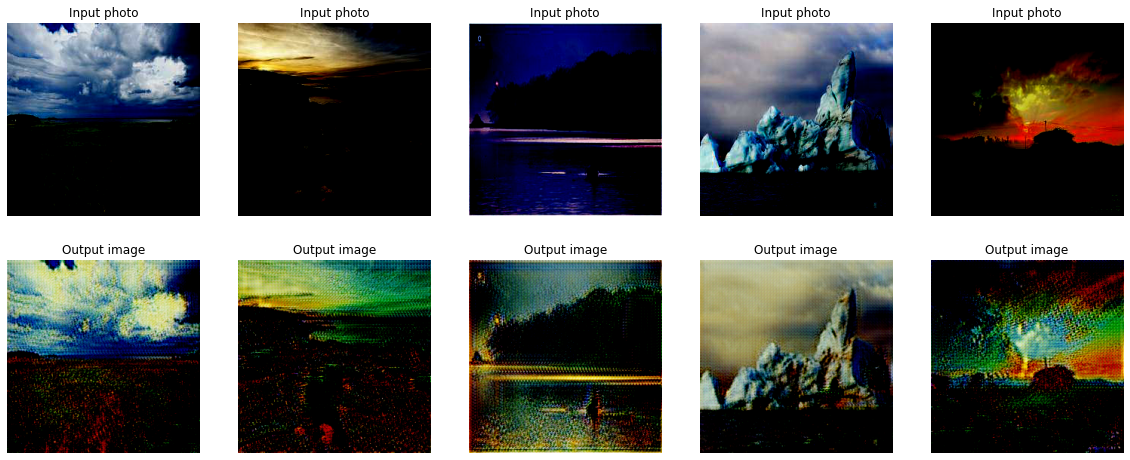

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 31/50 | Generators Loss: 3.3495 | Discriminators Loss: 0.3267


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 32/50 | Generators Loss: 3.2696 | Discriminators Loss: 0.3423


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 33/50 | Generators Loss: 3.2138 | Discriminators Loss: 0.3262


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 34/50 | Generators Loss: 3.1854 | Discriminators Loss: 0.3226


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 35/50 | Generators Loss: 3.1883 | Discriminators Loss: 0.3221


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 36/50 | Generators Loss: 3.1203 | Discriminators Loss: 0.3256


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 37/50 | Generators Loss: 3.0642 | Discriminators Loss: 0.3232


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 38/50 | Generators Loss: 3.0289 | Discriminators Loss: 0.3181


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 39/50 | Generators Loss: 3.0189 | Discriminators Loss: 0.3076


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 40/50 | Generators Loss: 2.9878 | Discriminators Loss: 0.3225


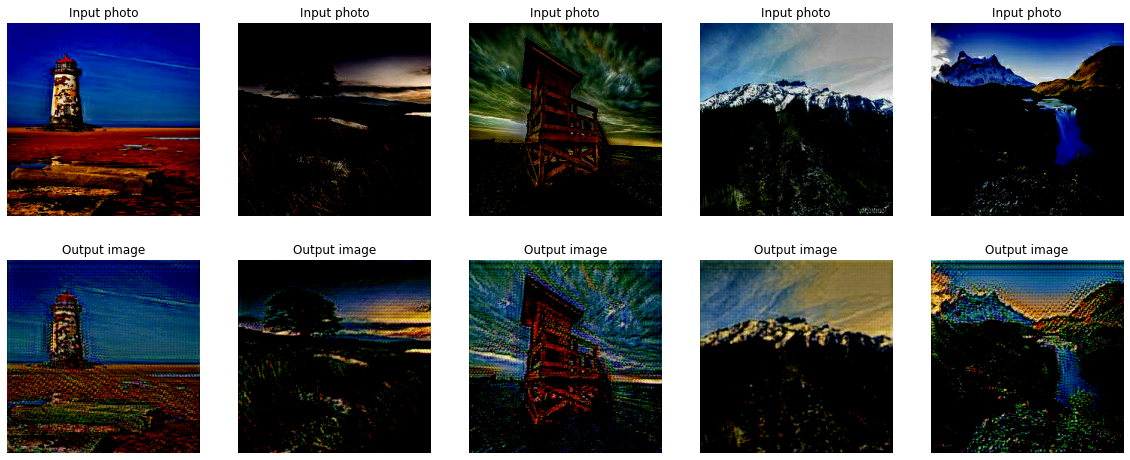

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 41/50 | Generators Loss: 2.9956 | Discriminators Loss: 0.2986


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 42/50 | Generators Loss: 2.8874 | Discriminators Loss: 0.2986


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 43/50 | Generators Loss: 2.8137 | Discriminators Loss: 0.3041


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 44/50 | Generators Loss: 2.8059 | Discriminators Loss: 0.2905


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 45/50 | Generators Loss: 2.7658 | Discriminators Loss: 0.3032


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 46/50 | Generators Loss: 2.7443 | Discriminators Loss: 0.2863


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 47/50 | Generators Loss: 2.7166 | Discriminators Loss: 0.2739


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 48/50 | Generators Loss: 2.6664 | Discriminators Loss: 0.2705


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 49/50 | Generators Loss: 2.6851 | Discriminators Loss: 0.2623


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 50/50 | Generators Loss: 2.5938 | Discriminators Loss: 0.2626


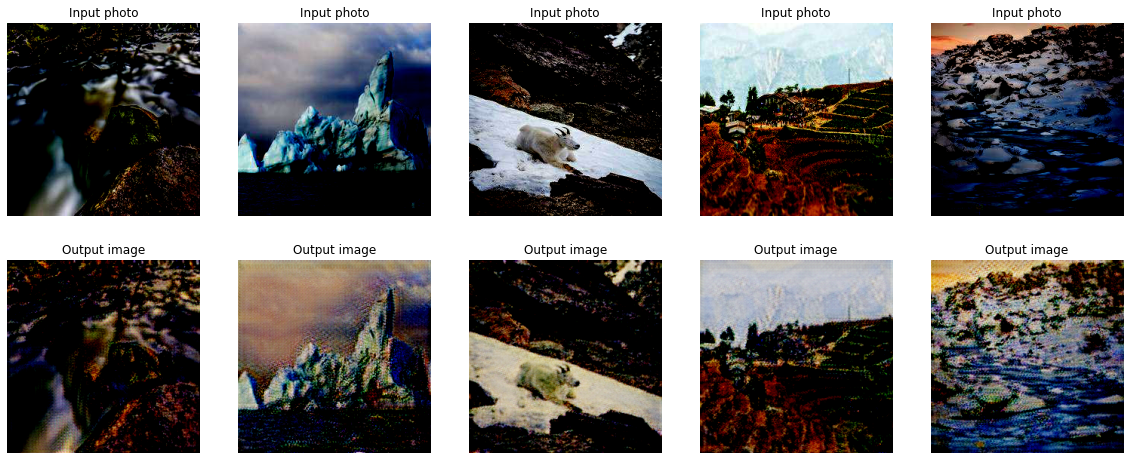

In [14]:
for epoch in range(num_epochs):
    avg_generators_loss = 0
    avg_discriminators_loss = 0
    
    for i, (real_monet, real_photo) in enumerate(tqdm(dataloader, leave=False, total=len(dataloader))):
        real_monet, real_photo = real_monet.to(device), real_photo.to(device)
                
        """ Train Generators """
        generator_monet2photo.train()
        generator_photo2monet.train()
        
        optim_generators.zero_grad()
        
        fake_photo = generator_monet2photo(real_monet)
        fake_monet = generator_photo2monet(real_photo)
        
        cycle_photo = generator_monet2photo(fake_monet)
        cycle_monet = generator_photo2monet(fake_photo)
        
        identity_photo = generator_monet2photo(real_photo)
        identity_monet = generator_photo2monet(real_monet)
        
        
        # GAN loss
        discriminator_outputs_photo = discriminator_photo(fake_photo)
        discriminator_outputs_monet = discriminator_monet(fake_monet)
        
        labels_real = torch.ones(discriminator_outputs_monet.size()).to(device)
        labels_fake = torch.zeros(discriminator_outputs_monet.size()).to(device)
        
        loss_GAN_monet2photo = criterion_GAN(discriminator_outputs_photo, labels_real)
        loss_GAN_photo2monet = criterion_GAN(discriminator_outputs_monet, labels_real)
        loss_GAN = (loss_GAN_monet2photo + loss_GAN_photo2monet) / 2
        
        # cycle loss
        loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
        loss_cycle_monet = criterion_cycle(cycle_monet, real_monet)
        loss_cycle = (loss_cycle_photo + loss_cycle_monet) / 2
        
        # identity loss
        loss_identity_photo = criterion_identity(identity_photo, real_photo)
        loss_identity_monet = criterion_identity(identity_monet, real_monet)
        loss_identity = (loss_identity_photo + loss_identity_monet) / 2
        
        # total loss
        loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity
        
        loss_generators_total.backward()
        optim_generators.step()
        
        
        """ Train Discriminators """
        optim_discriminators.zero_grad()
        
        loss_real_monet = criterion_GAN(discriminator_monet(real_monet), labels_real)
        loss_fake_monet = criterion_GAN(discriminator_monet(fake_monet.detach()), labels_fake)
        loss_monet = (loss_real_monet + loss_fake_monet) / 2
        
        loss_real_photo = criterion_GAN(discriminator_photo(real_photo), labels_real)
        loss_fake_photo = criterion_GAN(discriminator_photo(fake_photo.detach()), labels_fake)
        loss_photo = (loss_real_photo + loss_fake_photo) / 2
        
        loss_discriminators_total = loss_monet + loss_photo
        
        loss_discriminators_total.backward()
        optim_discriminators.step()
        
        avg_generators_loss += loss_generators_total.item()
        avg_discriminators_loss += loss_discriminators_total.item()
        
        
    avg_generators_loss /= len(dataloader)
    avg_discriminators_loss /= len(dataloader)
    history.update(avg_generators_loss, avg_discriminators_loss)
    
    # show intermediate results
    print("Epoch: %d/%d | Generators Loss: %.4f | Discriminators Loss: %.4f"
              % (epoch+1, num_epochs, avg_generators_loss, avg_discriminators_loss))
    
    if (epoch + 1) % 10 == 0:
        _, sample_real_photo = next(iter(dataloader))
        
        generator_photo2monet.eval()
        sample_fake_monet = generator_photo2monet(sample_real_photo.to(device)).detach().cpu()
        
        num_photos = min(batch_size, 5)
        plt.figure(figsize=(20, 8))
        for k in range(num_photos):
            plt.subplot(2, num_photos, k + 1)
            plt.imshow(sample_real_photo[k].permute(1, 2, 0))
            plt.title('Input photo')
            plt.axis('off')

            plt.subplot(2, num_photos, k + num_photos + 1)
            plt.imshow(sample_fake_monet[k].permute(1, 2, 0))
            plt.title('Output image')
            plt.axis('off')
        plt.show()
                  
    lr_sched_generators.step()
    lr_sched_discriminators.step()

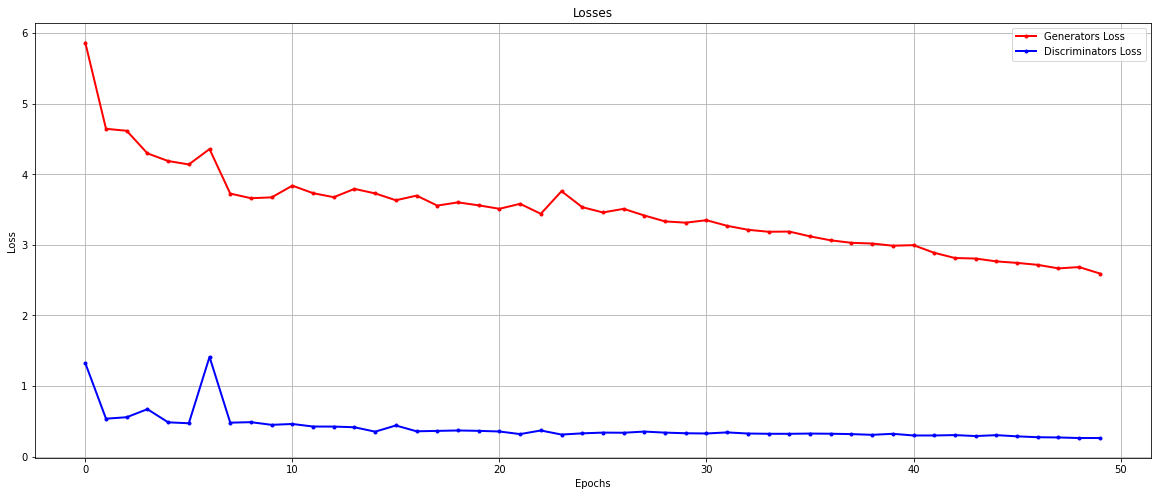

In [15]:
history.show()

# Create submission file

In [16]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [17]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [18]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

generator_photo2monet.eval()

for i in range(0, len(files), batch_size):
    images = []
    for j in range(i, min(len(files), i + batch_size)):
        image = Image.open(files[j])
        image = generate_transforms(image)
        images.append(image)
    real_photo = torch.stack(images, 0)
    
    fake_images = generator_photo2monet(real_photo.to(device)).detach().cpu()

    for j in range(fake_images.size(0)):
        img = fake_images[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)

        img = transforms.ToPILImage()(img_arr)
        img.save(os.path.join(save_dir, str(i + j + 1) + ".jpg"))

In [19]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

Public Score: 67.70520